# **1: Exploratory Data Analysis (EDA)**

Loading datasets...
Datasets loaded successfully!

Displaying sample images...


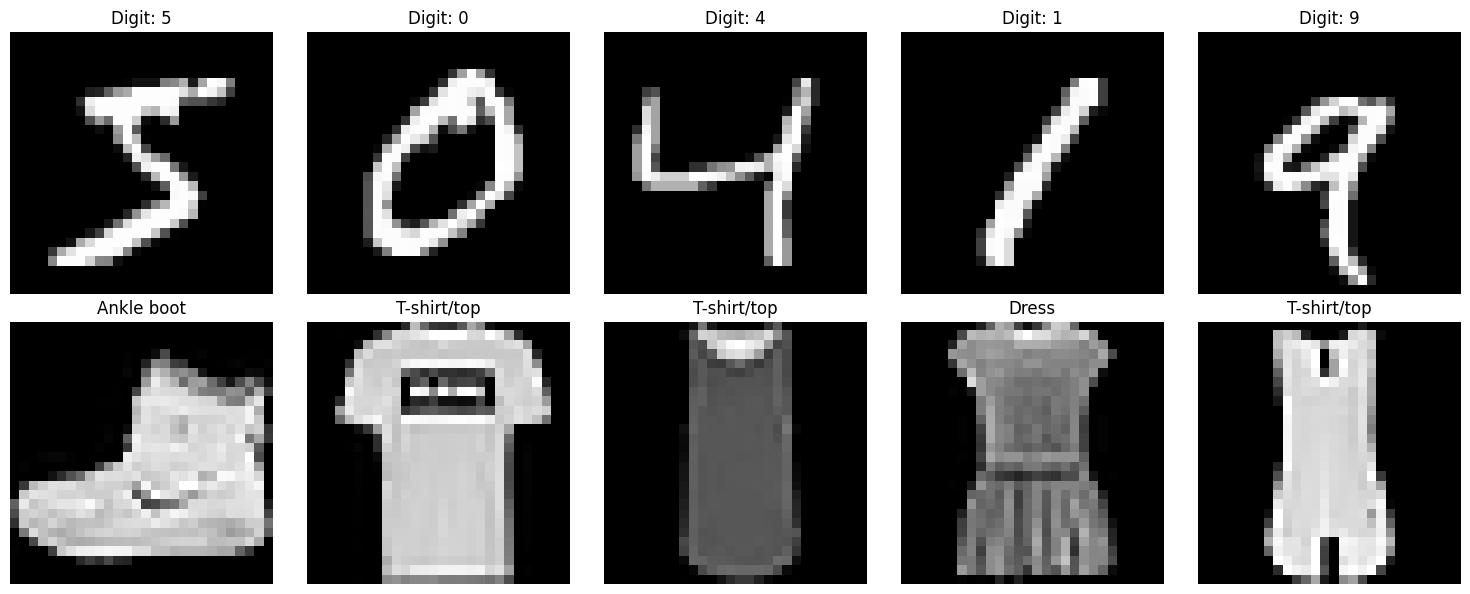


Analyzing datasets...
Dataset Sizes:
--------------------------------------------------
DIGITS MNIST:
Training samples: 60000
Testing samples: 10000
Total samples: 70000

FASHION MNIST:
Training samples: 60000
Testing samples: 10000
Total samples: 70000

Class Information:
--------------------------------------------------
MNIST Digits Classes: 0-9 (10 classes)
MNIST Fashion Classes:
Class 0: T-shirt/top
Class 1: Trouser
Class 2: Pullover
Class 3: Dress
Class 4: Coat
Class 5: Sandal
Class 6: Shirt
Class 7: Sneaker
Class 8: Bag
Class 9: Ankle boot


In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def load_datasets():
    """Load both MNIST Digits and Fashion datasets"""
    # Load MNIST Digits
    (x_train_digits, y_train_digits), (x_test_digits, y_test_digits) = tf.keras.datasets.mnist.load_data()

    # Load MNIST Fashion
    (x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = tf.keras.datasets.fashion_mnist.load_data()

    return {
        'digits': {
            'x_train': x_train_digits,
            'y_train': y_train_digits,
            'x_test': x_test_digits,
            'y_test': y_test_digits
        },
        'fashion': {
            'x_train': x_train_fashion,
            'y_train': y_train_fashion,
            'x_test': x_test_fashion,
            'y_test': y_test_fashion
        }
    }

def display_samples(datasets, num_samples=5):
    """Display sample images from both datasets"""
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    # Labels for both datasets
    digits_labels = list(range(10))
    fashion_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                     'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    # Display MNIST Digits samples
    for i in range(num_samples):
        axes[0, i].imshow(datasets['digits']['x_train'][i], cmap='gray')
        axes[0, i].set_title(f'Digit: {digits_labels[datasets["digits"]["y_train"][i]]}')
        axes[0, i].axis('off')

    # Display Fashion MNIST samples
    for i in range(num_samples):
        axes[1, i].imshow(datasets['fashion']['x_train'][i], cmap='gray')
        axes[1, i].set_title(f'{fashion_labels[datasets["fashion"]["y_train"][i]]}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

def analyze_datasets(datasets):
    """Analyze basic properties of both datasets"""
    # Dataset sizes
    print("Dataset Sizes:")
    print("-" * 50)
    for dataset_name in datasets:
        train_size = len(datasets[dataset_name]['x_train'])
        test_size = len(datasets[dataset_name]['x_test'])
        total_size = train_size + test_size
        print(f"{dataset_name.upper()} MNIST:")
        print(f"Training samples: {train_size}")
        print(f"Testing samples: {test_size}")
        print(f"Total samples: {total_size}")
        print()

    # Class information
    print("Class Information:")
    print("-" * 50)
    print("MNIST Digits Classes: 0-9 (10 classes)")
    print("MNIST Fashion Classes:")
    fashion_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                     'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    for i, label in enumerate(fashion_labels):
        print(f"Class {i}: {label}")

# Main execution
if __name__ == "__main__":
    # 1. Load the datasets
    print("Loading datasets...")
    datasets = load_datasets()
    print("Datasets loaded successfully!\n")

    # 2. Display sample images
    print("Displaying sample images...")
    display_samples(datasets)

    # 3. Analyze datasets
    print("\nAnalyzing datasets...")
    analyze_datasets(datasets)

In [ ]:
!pip install tensorflow matplotlib numpy

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


# **Part 2: Implementing Generative Adversarial Networks**
# **GANs for MNIST-Digits**

In [ ]:
# Load datasets
(x_train_digits, _), (_, _) = tf.keras.datasets.mnist.load_data()
(x_train_fashion, y_train_fashion), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# Select only the "Shoe" class (label 9) from Fashion MNIST
shoe_class = 9
x_train_shoes = x_train_fashion[y_train_fashion.flatten() == shoe_class]


# Normalize images to [-1, 1] range
def preprocess_images(images):
    images = (images.astype("float32") - 127.5) / 127.5  # Normalize to [-1,1]
    return images.reshape(images.shape[0], 28, 28, 1)

x_train_digits = preprocess_images(x_train_digits)
x_train_shoes = preprocess_images(x_train_shoes)

# Create TensorFlow datasets
batch_size = min(64, len(x_train_shoes))  # Adjust batch size dynamically
train_digits = tf.data.Dataset.from_tensor_slices(x_train_digits).shuffle(60000).batch(batch_size)
train_shoes = tf.data.Dataset.from_tensor_slices(x_train_shoes).shuffle(len(x_train_shoes)).batch(batch_size)


In [ ]:
def make_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),

        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = make_generator()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def make_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)


In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # ✅ Ensure valid gradients before applying
    if None not in gradients_of_generator and None not in gradients_of_discriminator:
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    else:
        print("⚠️ Gradient issue detected, skipping update.")

    return gen_loss, disc_loss


In [ ]:
import time

def train(dataset, epochs, model_name="mnist"):
    gen_losses, disc_losses = [], []

    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        gen_losses.append(gen_loss.numpy())
        disc_losses.append(disc_loss.numpy())

        # Print loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")

        # Generate & Save Sample Images every 50 epochs
        if (epoch + 1) % 50 == 0:
            generate_and_save_images(generator, epoch+1, model_name)

        print(f'Time for epoch {epoch+1} is {time.time()-start:.2f} sec')

    # Plot loss curves
    plot_loss(gen_losses, disc_losses, model_name)

def generate_and_save_images(model, epoch, model_name):
    noise = tf.random.normal([16, 100])
    generated_images = model(noise, training=False)

    fig, axes = plt.subplots(4, 4, figsize=(4,4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        ax.axis('off')
    plt.savefig(f'{model_name}_epoch_{epoch}.png')
    plt.close()

def plot_loss(gen_losses, disc_losses, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Loss Curves - {model_name}")
    plt.savefig(f"{model_name}_loss_curve.png")
    plt.show()


Time for epoch 1 is 17.18 sec
Time for epoch 2 is 11.58 sec
Time for epoch 3 is 11.66 sec
Time for epoch 4 is 11.78 sec
Time for epoch 5 is 11.87 sec
Time for epoch 6 is 20.46 sec
Time for epoch 7 is 11.95 sec
Time for epoch 8 is 12.10 sec
Time for epoch 9 is 11.97 sec
Epoch 10, Gen Loss: 0.7793, Disc Loss: 1.2839
Time for epoch 10 is 12.02 sec
Time for epoch 11 is 12.08 sec
Time for epoch 12 is 12.11 sec
Time for epoch 13 is 12.15 sec
Time for epoch 14 is 12.15 sec
Time for epoch 15 is 12.22 sec
Time for epoch 16 is 12.25 sec
Time for epoch 17 is 12.25 sec
Time for epoch 18 is 12.29 sec
Time for epoch 19 is 12.28 sec
Epoch 20, Gen Loss: 0.6821, Disc Loss: 1.3373
Time for epoch 20 is 12.28 sec
Time for epoch 21 is 12.24 sec
Time for epoch 22 is 12.26 sec
Time for epoch 23 is 12.24 sec
Time for epoch 24 is 12.24 sec
Time for epoch 25 is 12.24 sec
Time for epoch 26 is 12.25 sec
Time for epoch 27 is 12.25 sec
Time for epoch 28 is 12.25 sec
Time for epoch 29 is 12.25 sec
Epoch 30, Gen Loss

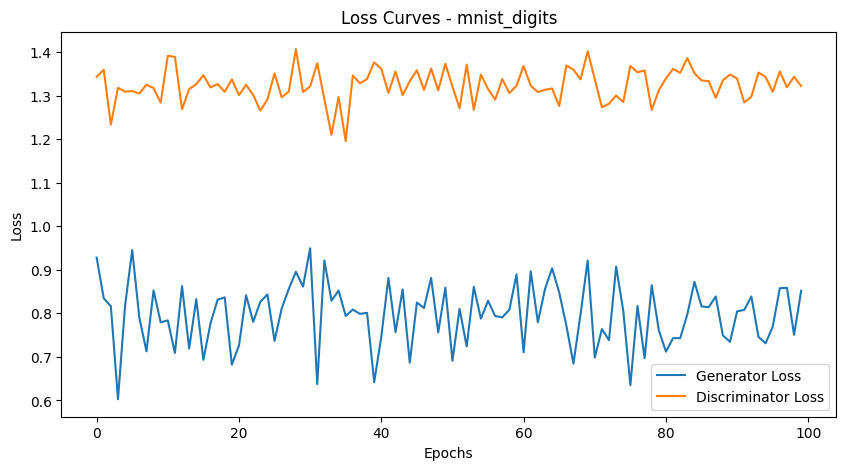

In [ ]:
train(train_digits, epochs=100, model_name="mnist_digits")


# **10 newly generated images**

<ipython-input-23-6958676e6022>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("MNIST_Digits_generator.pth"))


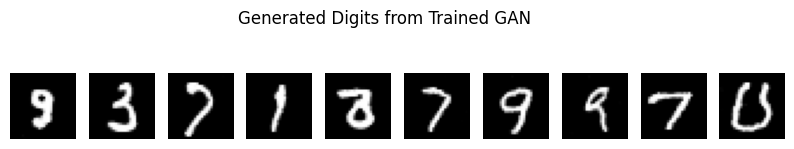

In [ ]:
def generate_images(num_samples=10):
    noise = torch.randn(num_samples, 100, device=device)  # Random latent vectors
    gen_images = generator(noise).detach().cpu()  # Generate images

    # Plot generated images
    fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
    for i in range(num_samples):
        axes[i].imshow(gen_images[i].squeeze(), cmap='gray')
        axes[i].axis('off')

    plt.suptitle("Generated Images from Trained GAN")
    plt.show()

# Generate and display images
generate_images(10)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize data to [0,1] range
x_train, x_test = x_train / 255.0, x_test / 255.0

# Expand dimensions (CNN expects 4D input: (batch, height, width, channels))
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Build a simple CNN model
classifier = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 output classes (digits 0-9)
])

# Compile the model
classifier.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Train the model
classifier.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# Save the trained classifier
classifier.save("mnist_classifier.h5")

print("MNIST classifier saved as mnist_classifier.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9066 - loss: 0.2889 - val_accuracy: 0.9864 - val_loss: 0.0416
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9867 - loss: 0.0429 - val_accuracy: 0.9857 - val_loss: 0.0417
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9913 - loss: 0.0283 - val_accuracy: 0.9881 - val_loss: 0.0392
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9939 - loss: 0.0200 - val_accuracy: 0.9907 - val_loss: 0.0327
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9948 - loss: 0.0155 - val_accuracy: 0.9897 - val_loss: 0.0385


MNIST classifier saved as mnist_classifier.h5


# **Generated images of the digit "3"**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


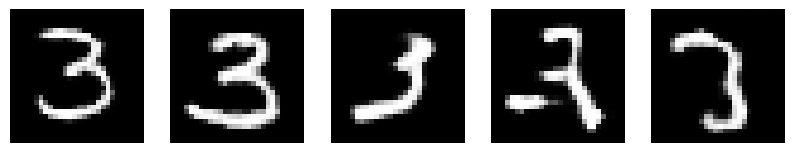

In [ ]:
def generate_and_display_images(model, num_images=10):
    noise = tf.random.normal([num_images, 100])
    generated_images = model(noise, training=False)

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

# Generate and display images from the trained MNIST GAN
# Generate 5 images of digit '3'
generate_specific_digit(generator, mnist_classifier, target_digit=3, num_images=5)


Number of shoe images: 6000


# **GANs for MNIST Fashion**

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Number of shoe images: 6000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Time for epoch 1 is 29.74 sec
Time for epoch 2 is 17.49 sec
Time for epoch 3 is 19.03 sec
Time for epoch 4 is 17.51 sec
Time for epoch 5 is 18.07 sec
Time for epoch 6 is 17.60 sec
Time for epoch 7 is 20.46 sec
Time for epoch 8 is 17.54 sec
Time for epoch 9 is 18.22 sec
Epoch 10, Gen Loss: 0.7455, Disc Loss: 1.3486
Time for epoch 10 is 17.42 sec
Time for epoch 11 is 17.70 sec
Time for epoch 12 is 17.95 sec
Time for epoch 13 is 17.54 sec
Time for epoch 14 is 18.23 sec
Time for epoch 15 is 17.44 sec
Time for epoch 16 is 20.46 sec
Time for epoch 17 is 17.45 sec
Time for epoch 18 is 18.15 sec
Time for epoch 19 is 17.43 sec
Epoch 20, Gen Loss: 0.7326, Disc Loss: 1.3859
Time for epoch 20 is 20.46 sec
Time for epoch 21 is 17.49 sec
Time for epoch 22 is 20.46 sec
Time for epoch 23 is 17.56 sec
Time for epoch 24 is 18.27 sec
Time for epoch 25 is 17.38 sec
Time for epoch 26 is 20.46 sec
Time for epoch 27 is 17.49 sec
Time for epoch 28 is 20.46 sec
Time for epoch 29 is 17.48 sec
Epoch 30, Gen Loss

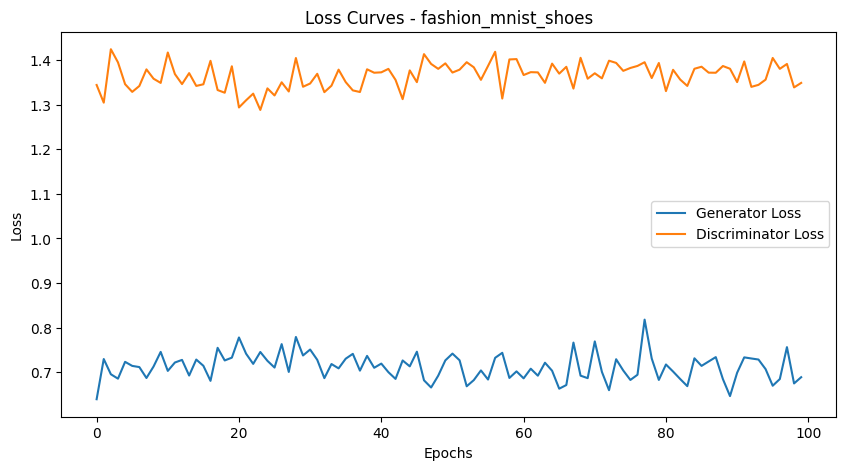

In [1]:
# Install dependencies (if running in a fresh environment)
!pip install tensorflow matplotlib numpy

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
(x_train_digits, _), (_, _) = tf.keras.datasets.mnist.load_data()
(x_train_fashion, y_train_fashion), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# Select only the "Shoe" class (label 9) from Fashion MNIST
shoe_class = 9
x_train_shoes = x_train_fashion[y_train_fashion.flatten() == shoe_class]

# Check if dataset is empty
print(f"Number of shoe images: {len(x_train_shoes)}")
if len(x_train_shoes) == 0:
    raise ValueError("❌ No shoe images found in Fashion MNIST!")

# Normalize images to [-1, 1] range
def preprocess_images(images):
    images = (images.astype("float32") - 127.5) / 127.5  # Normalize to [-1,1]
    return images.reshape(images.shape[0], 28, 28, 1)

x_train_digits = preprocess_images(x_train_digits)
x_train_shoes = preprocess_images(x_train_shoes)

# Create TensorFlow datasets
batch_size = min(64, len(x_train_shoes))  # Adjust batch size dynamically
train_digits = tf.data.Dataset.from_tensor_slices(x_train_digits).shuffle(60000).batch(batch_size)
train_shoes = tf.data.Dataset.from_tensor_slices(x_train_shoes).shuffle(len(x_train_shoes)).batch(batch_size)

# ✅ Model Definitions
def make_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),

        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = make_generator()

def make_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator()

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

# ✅ Training Function
def train_step(images):
    noise = tf.random.normal([images.shape[0], 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # ✅ Check if gradients are None before applying
    if None not in gradients_of_generator and None not in gradients_of_discriminator:
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    else:
        print("⚠️ Gradient issue detected, skipping update.")

    return gen_loss, disc_loss

import time

def train(dataset, epochs, model_name="mnist"):
    gen_losses, disc_losses = [], []

    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        gen_losses.append(gen_loss.numpy())
        disc_losses.append(disc_loss.numpy())

        # Print loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")

        # Generate & Save Sample Images every 50 epochs
        if (epoch + 1) % 50 == 0:
            generate_and_save_images(generator, epoch+1, model_name)

        print(f'Time for epoch {epoch+1} is {time.time()-start:.2f} sec')

    # Plot loss curves
    plot_loss(gen_losses, disc_losses, model_name)

def generate_and_save_images(model, epoch, model_name):
    noise = tf.random.normal([16, 100])
    generated_images = model(noise, training=False)

    fig, axes = plt.subplots(4, 4, figsize=(4,4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        ax.axis('off')
    plt.savefig(f'{model_name}_epoch_{epoch}.png')
    plt.close()

def plot_loss(gen_losses, disc_losses, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Loss Curves - {model_name}")
    plt.savefig(f"{model_name}_loss_curve.png")
    plt.show()

# ✅ Train GAN on Fashion MNIST Shoes
train(train_shoes, epochs=100, model_name="fashion_mnist_shoes")


# **Generate images from fashion dataset like shoe**

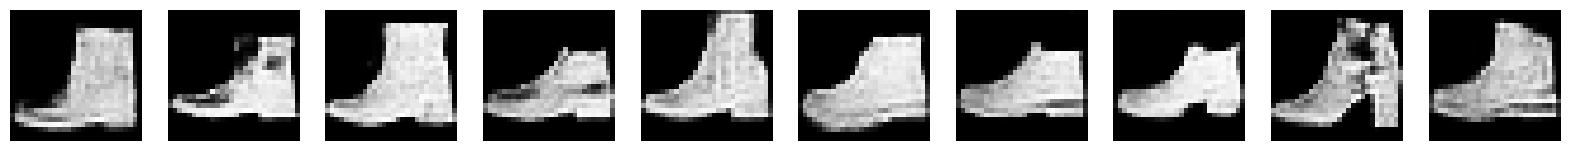

In [2]:
def generate_and_display_images(model, num_images=10):
    noise = tf.random.normal([num_images, 100])  # Generate noise
    generated_images = model(noise, training=False)  # Generate images

    # Plot generated images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        axes[i].imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        axes[i].axis('off')

    plt.show()

# ✅ Display 10 newly generated images
generate_and_display_images(generator, num_images=10)


# **VAE for mnist digits**

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# MNIST Dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:10<00:00, 903kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 57.9kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.85MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [10]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))  # Flatten the image
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [11]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL divergence between the learned latent distribution and standard normal distribution
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [ ]:
# Hyperparameters
latent_dim = 20
hidden_dim = 400
input_dim = 784
learning_rate = 0.001
num_epochs = 10

# Initialize the model and optimizer
model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(torch.device("cpu"))  # Move data to device
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}")


Epoch 1, Loss: 146.42154809977214
Epoch 2, Loss: 115.8373345703125
Epoch 3, Loss: 111.38280330403646
Epoch 4, Loss: 109.45349287516277
Epoch 5, Loss: 108.15919503987631
Epoch 6, Loss: 107.37516146240235
Epoch 7, Loss: 106.79330115559895
Epoch 8, Loss: 106.3738504720052
Epoch 9, Loss: 105.9467810953776
Epoch 10, Loss: 105.62482123209635


In [ ]:
# Save the trained model
torch.save(model.state_dict(), "vae_model.pth")
print("Model saved as 'vae_model.pth'")

Model saved as 'vae_model.pth'


# **Latent Space**

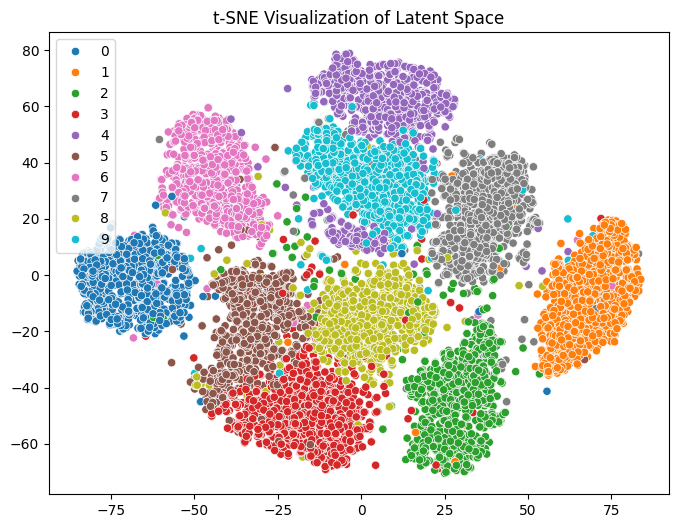

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

# Get latent vectors for visualization
def get_latent_vectors(model, loader):
    model.eval()
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for data, label in loader:
            data = data.to(torch.device("cpu"))
            mu, logvar = model.encode(data.view(-1, 784))
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z)
            labels.append(label)

    latent_vectors = torch.cat(latent_vectors).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()
    return latent_vectors, labels

latent_vectors, labels = get_latent_vectors(model, test_loader)

# Perform t-SNE
tsne = TSNE(n_components=2)
latent_tsne = tsne.fit_transform(latent_vectors)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_tsne[:, 0], y=latent_tsne[:, 1], hue=labels, palette='tab10', legend='full')
plt.title("t-SNE Visualization of Latent Space")
plt.show()


# **Generating new images**

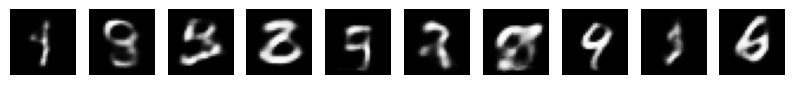

In [ ]:
def generate_new_images(model, num_samples=10):
    model.eval()
    with torch.no_grad():
        # Sample random latent vectors from a normal distribution
        z = torch.randn(num_samples, latent_dim).to(torch.device("cpu"))
        generated_images = model.decode(z)
        generated_images = generated_images.view(num_samples, 28, 28).cpu().numpy()

        # Plot the generated images
        plt.figure(figsize=(10, 2))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(generated_images[i], cmap='gray')
            plt.axis('off')
        plt.show()

# Generate and display new images
generate_new_images(model)


In [ ]:
trained_vae_model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
trained_vae_model.load_state_dict(torch.load("vae_model.pth"))
trained_vae_model.eval()  # Set the model to evaluation mode


<ipython-input-13-559d764a3357>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_vae_model.load_state_dict(torch.load("vae_model.pth"))


VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc_mu): Linear(in_features=400, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=400, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=784, bias=True)
)

<ipython-input-25-c04b75694f4d>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_vae_model.load_state_dict(torch.load("vae_model.pth"))


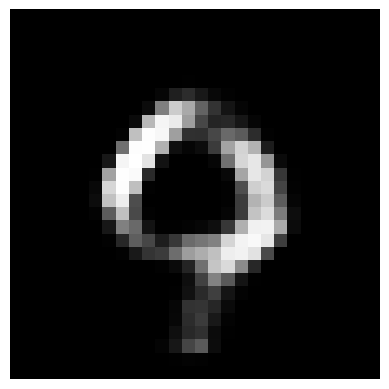

In [ ]:
import torch
import matplotlib.pyplot as plt

# Function to generate a specific digit using stored latent vectors
def generate_specific_digit(vae_model, latent_vector):
    vae_model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        generated_digit = vae_model.decode(latent_vector)
    return generated_digit

# Load the trained VAE model
latent_dim = 20  # Ensure latent dimension is correct
input_dim = 784
hidden_dim = 400

# Instantiate the model and load the pre-trained weights
trained_vae_model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
trained_vae_model.load_state_dict(torch.load("vae_model.pth"))
trained_vae_model.eval()  # Set the model to evaluation mode

# Example: Generate digit from a random latent vector
latent_vector = torch.randn(1, latent_dim)  # Generate a random latent vector
generated_digit = generate_specific_digit(trained_vae_model, latent_vector)

# Reshape the generated digit from (1, 784) to (28, 28)
generated_digit = generated_digit.view(28, 28)

# Plot the generated digit
plt.imshow(generated_digit.cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()


# **Generate Specific digit**

<ipython-input-29-b2c988ceb851>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_vae_model.load_state_dict(torch.load("vae_model.pth"))


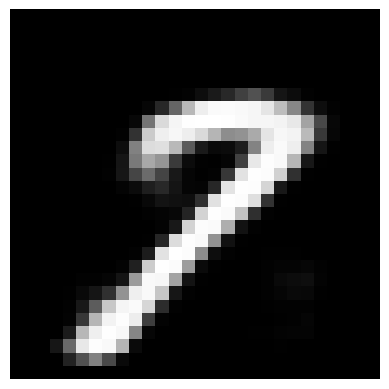

In [ ]:
import torch
import matplotlib.pyplot as plt

# Function to generate a specific digit using stored latent vectors
def generate_specific_digit(vae_model, latent_vector):
    vae_model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        generated_digit = vae_model.decode(latent_vector)
    return generated_digit

# Function to encode a known digit and get its latent vector
def get_latent_vector(vae_model, digit, data_loader):
    vae_model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data, target in data_loader:
            # Find the first image in the dataset matching the target digit
            mask = target == digit
            if mask.any():
                input_image = data[mask][0].view(-1, 784)  # Get the first match and flatten the image
                _, mu, _ = vae_model(input_image)  # Get the mean (mu) from the encoder
                return mu
    return None

# Load the trained VAE model
latent_dim = 20  # Ensure latent dimension is correct
input_dim = 784
hidden_dim = 400

# Instantiate the model and load the pre-trained weights
trained_vae_model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
trained_vae_model.load_state_dict(torch.load("vae_model.pth"))
trained_vae_model.eval()  # Set the model to evaluation mode

# Example: Get the latent vector for the digit "7" from the training data
digit_to_generate = 7
latent_vector = get_latent_vector(trained_vae_model, digit_to_generate, train_loader)

if latent_vector is not None:
    # Generate the specific digit using the latent vector
    generated_digit = generate_specific_digit(trained_vae_model, latent_vector)

    # Reshape the generated digit from (1, 784) to (28, 28)
    generated_digit = generated_digit.view(28, 28)

    # Plot the generated digit
    plt.imshow(generated_digit.cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()
else:
    print(f"Latent vector for digit {digit_to_generate} not found.")


# **Generate 10 images **

<ipython-input-27-02ca934145ff>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_vae_model.load_state_dict(torch.load("vae_model.pth"))


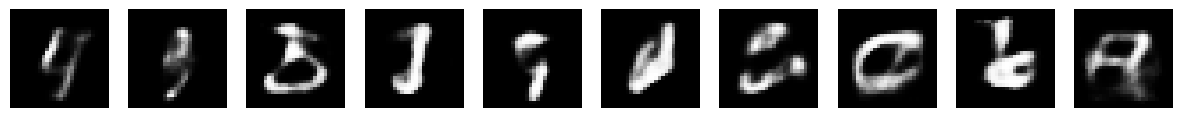

In [ ]:
import torch
import matplotlib.pyplot as plt

# Function to generate multiple digits using random latent vectors
def generate_multiple_digits(vae_model, latent_dim, num_digits=10):
    vae_model.eval()  # Set model to evaluation mode
    generated_digits = []
    with torch.no_grad():
        for _ in range(num_digits):
            latent_vector = torch.randn(1, latent_dim)  # Generate a random latent vector
            generated_digit = vae_model.decode(latent_vector)
            generated_digits.append(generated_digit.view(28, 28))  # Reshape to 28x28
    return generated_digits

# Load the trained VAE model
latent_dim = 20  # Ensure latent dimension is correct
input_dim = 784
hidden_dim = 400

# Instantiate the model and load the pre-trained weights
trained_vae_model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
trained_vae_model.load_state_dict(torch.load("vae_model.pth"))
trained_vae_model.eval()  # Set the model to evaluation mode

# Generate 10 random digits
num_digits = 10
generated_digits = generate_multiple_digits(trained_vae_model, latent_dim, num_digits)

# Plot the 10 generated digits in a grid
fig, axes = plt.subplots(1, num_digits, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(generated_digits[i].cpu().numpy(), cmap='gray')
    ax.axis('off')

plt.show()


Number of '2' images: 5958
Time for epoch 1 is 20.48 sec
Time for epoch 2 is 20.46 sec
Time for epoch 3 is 18.20 sec
Time for epoch 4 is 18.50 sec
Time for epoch 5 is 18.15 sec
Time for epoch 6 is 17.32 sec
Time for epoch 7 is 17.69 sec
Time for epoch 8 is 18.50 sec
Time for epoch 9 is 17.36 sec
Epoch 10, Gen Loss: 0.7127, Disc Loss: 1.3306
Time for epoch 10 is 17.94 sec
Time for epoch 11 is 17.20 sec
Time for epoch 12 is 18.02 sec
Time for epoch 13 is 17.29 sec
Time for epoch 14 is 20.46 sec
Time for epoch 15 is 17.32 sec


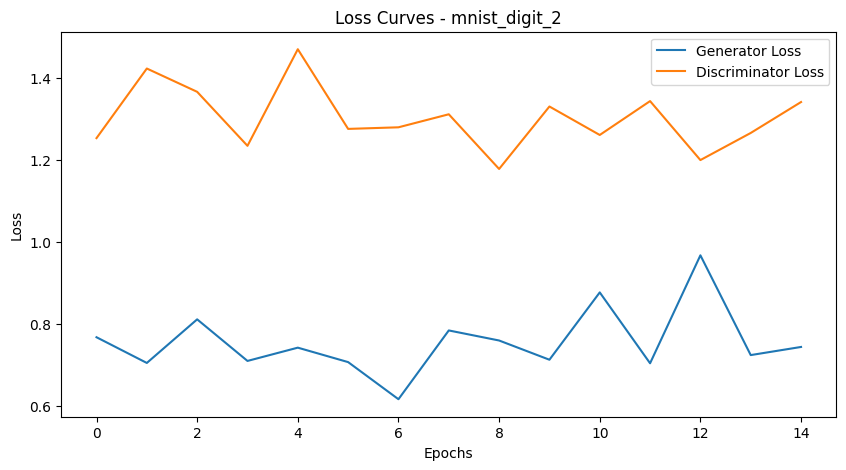

In [4]:
# Load MNIST dataset
(x_train_digits, y_train_digits), (_, _) = tf.keras.datasets.mnist.load_data()

# Select only the digit "2" (label 2)
digit_class = 2
x_train_digit2 = x_train_digits[y_train_digits.flatten() == digit_class]

print(f"Number of '2' images: {len(x_train_digit2)}")
if len(x_train_digit2) == 0:
    raise ValueError("❌ No digit '2' images found in MNIST!")

# Preprocess images (Normalize & Reshape)
x_train_digit2 = preprocess_images(x_train_digit2)

# Create TensorFlow dataset
batch_size = min(64, len(x_train_digit2))
train_digit2 = tf.data.Dataset.from_tensor_slices(x_train_digit2).shuffle(len(x_train_digit2)).batch(batch_size)

# ✅ Train GAN on digit "2"
train(train_digit2, epochs=15, model_name="mnist_digit_2")


# **Generate digit 2**

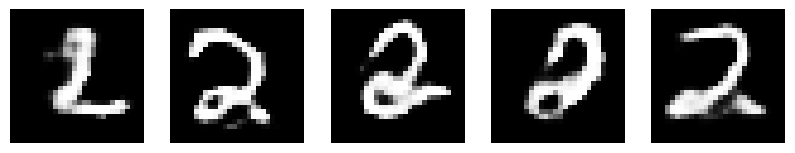

In [5]:
def generate_and_display_images(model, num_images=5):
    noise = tf.random.normal([num_images, 100])  # Generate noise input
    generated_images = model(noise, training=False)  # Generate images

    # Display images in a row
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        axes[i].imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        axes[i].axis('off')

    plt.show()

# ✅ Generate & display 5 new images of digit "2"
generate_and_display_images(generator, num_images=5)


# **VAE for MNIST fashion**

In [13]:
# ✅ Load Fashion MNIST Dataset instead of MNIST
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader_fashion= DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader_fashion = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [14]:
# Hyperparameters
latent_dim = 20
hidden_dim = 400
input_dim = 784
learning_rate = 0.001
num_epochs = 10

# Initialize the model and optimizer
model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader_fashion):
        data = data.to(torch.device("cpu"))  # Move data to device
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader_fashion.dataset)}")


Epoch 1, Loss: 273.8086164713542
Epoch 2, Loss: 251.53285751953126
Epoch 3, Loss: 247.46093704427082
Epoch 4, Loss: 245.46970173339844
Epoch 5, Loss: 244.27629252929688
Epoch 6, Loss: 243.40223247070313
Epoch 7, Loss: 242.7434246907552
Epoch 8, Loss: 242.26598334960937
Epoch 9, Loss: 241.8681941813151
Epoch 10, Loss: 241.48274768066406


In [15]:
# Save the trained model
torch.save(model.state_dict(), "vae_model_fashion.pth")
print("Model saved as 'vae_model_fashion.pth'")

Model saved as 'vae_model_fashion.pth'


# **latent space**

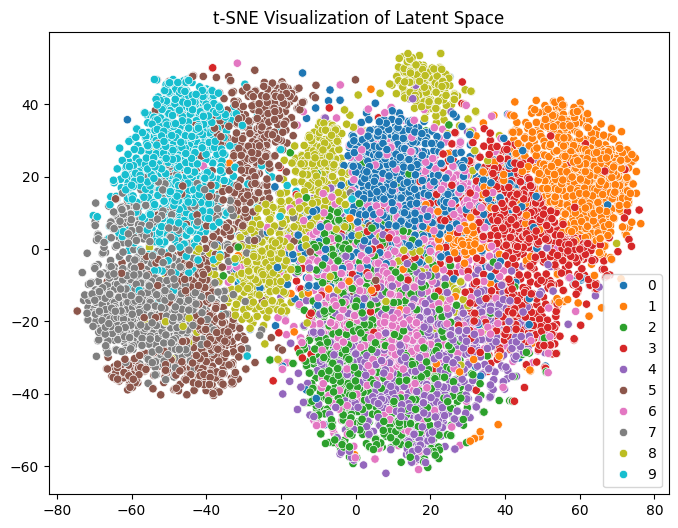

In [16]:
from sklearn.decomposition import PCA
import seaborn as sns

# Get latent vectors for visualization
def get_latent_vectors(model, loader):
    model.eval()
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for data, label in loader:
            data = data.to(torch.device("cpu"))
            mu, logvar = model.encode(data.view(-1, 784))
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z)
            labels.append(label)

    latent_vectors = torch.cat(latent_vectors).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()
    return latent_vectors, labels

latent_vectors, labels = get_latent_vectors(model, test_loader_fashion)

# Perform t-SNE
tsne = TSNE(n_components=2)
latent_tsne = tsne.fit_transform(latent_vectors)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_tsne[:, 0], y=latent_tsne[:, 1], hue=labels, palette='tab10', legend='full')
plt.title("t-SNE Visualization of Latent Space")
plt.show()


# **Generate new image**

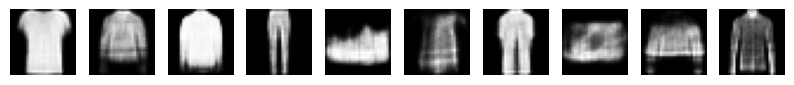

In [20]:
def generate_new_images(model, num_samples=10):
    model.eval()
    with torch.no_grad():
        # Sample random latent vectors from a normal distribution
        z = torch.randn(num_samples, latent_dim).to(torch.device("cpu"))
        generated_images = model.decode(z)
        generated_images = generated_images.view(num_samples, 28, 28).cpu().numpy()

        # Plot the generated images
        plt.figure(figsize=(10, 2))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(generated_images[i], cmap='gray')
            plt.axis('off')
        plt.show()

# Generate and display new images
generate_new_images(model)

# **Generate specific image**

<ipython-input-28-a387608693b7>:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_vae_model.load_state_dict(torch.load("vae_model_fashion.pth"))


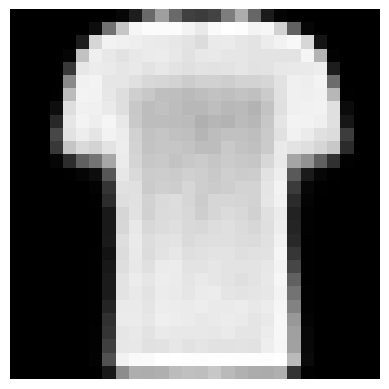

In [28]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Function to generate a specific fashion item using stored latent vectors
def generate_specific_fashion_item(vae_model, latent_vector):
    vae_model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        generated_item = vae_model.decode(latent_vector)
    return generated_item

# Function to encode a known fashion item and get its latent vector
def get_latent_vector_fashion(vae_model, target_label, data_loader):
    vae_model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data, target in data_loader:
            # Find the first image in the dataset matching the target fashion item
            mask = target == target_label
            if mask.any():
                input_image = data[mask][0].view(-1, 784)  # Get the first match and flatten the image
                _, mu, _ = vae_model(input_image)  # Get the mean (mu) from the encoder
                return mu
    return None

# Load the Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load the trained VAE model
latent_dim = 20  # Ensure latent dimension is correct
input_dim = 784  # 28 * 28 images flattened
hidden_dim = 400

# Instantiate the model and load the pre-trained weights
trained_vae_model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
trained_vae_model.load_state_dict(torch.load("vae_model_fashion.pth"))
trained_vae_model.eval()  # Set the model to evaluation mode

# Define fashion item label to generate (0 = T-shirt/top, 1 = Trouser, ..., 9 = Ankle boot)


target_fashion_item = 0 # For example, "Sneaker" (Change this based on the item you want)


# Get the latent vector for the specific fashion item
latent_vector = get_latent_vector_fashion(trained_vae_model, target_fashion_item, train_loader)

if latent_vector is not None:
    # Generate the specific fashion item using the latent vector
    generated_fashion_item = generate_specific_fashion_item(trained_vae_model, latent_vector)

    # Reshape the generated fashion item from (1, 784) to (28, 28)
    generated_fashion_item = generated_fashion_item.view(28, 28)

    # Plot the generated fashion item
    plt.imshow(generated_fashion_item.cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()
else:
    print(f"Latent vector for fashion item {target_fashion_item} not found.")
# MNIST Fashion Classes:
# Class 0: T-shirt/top
# Class 1: Trouser
# Class 2: Pullover
# Class 3: Dress
# Class 4: Coat
# Class 5: Sandal
# Class 6: Shirt
# Class 7: Sneaker
# Class 8: Bag
# Class 9: Ankle boot